# Cutting pattern Niihama +
for Fujii-Echelle

Balmer series:

|line     | $\lambda$, nm|
|--       |            --|
|H $\alpha$ |656.279       |
|H $\beta$  |486.135       |

I don't have time to make this fully automated. The configuration of a particular spectrometer 
determines the shape of diffraction orders. So we can just copy approximate equations 
for each order line. (Same excuse as Niihama has)

## Imports and Setup

In [1]:
%matplotlib inline

In [2]:
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import peakutils
import pandas as pd
from PIL import Image
from aklab.mpls import font_setup
from lmfit.models import GaussianModel
from scipy.signal import savgol_filter

In [3]:
from PIL import Image

In [4]:
tifim = Image.open('LED.tif')
print(f'N(frames) = {tifim.n_frames}')
# Transpose to get the lines closer to horizontal
image = np.array(tifim).T
# Crop image
image = image[1400:2600]

N(frames) = 1


In [5]:
#sekibun = image[1400:2600].T
sekibun = image.T
sekibun = sekibun - sekibun.min()

In [6]:
# y pixel - chane in order
# x pixel - change in wavelength
nx,ny = sekibun.shape

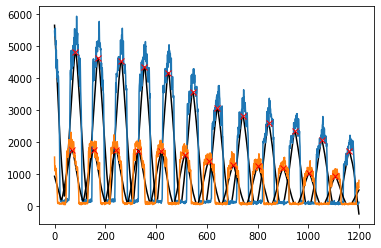

In [7]:
# profile along pixel x = i
xsection = [0,nx-1]
THRESHOLD = 0.06
MIN_DISTANCE = 60 

peaksy = []
clr = ['C0','C1']
for j,xi in enumerate(xsection):
    d = savgol_filter(sekibun[xi],41,1)
    peaks = peakutils.indexes(d,thres=THRESHOLD,min_dist=MIN_DISTANCE)
    py = np.arange(ny)[peaks]
    peaksy.append(py)
    plt.plot(d,'k')
    plt.plot(sekibun[xi],c=clr[j])
    plt.plot(py,d[peaks],'xr')

# Only works if on each line same number of peaks is detected
# Numpy doesn't like uneven arrays
peaksy = np.array(peaksy)

In [8]:
half_width = 15
line_k = 250/nx

(-100.0, 2404.0)

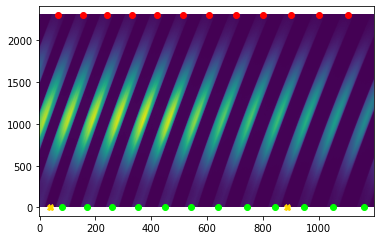

In [9]:
plt.imshow(sekibun,aspect = 0.3,origin='lower')
clr = ['lime','r']
offset = [peaksy[0,0]-half_width*3,peaksy[-1,-1]-line_k*nx + half_width*2]
for j,xi in enumerate(xsection):
    plt.plot(peaksy[j],np.ones(len(peaksy[j]))*xi,'o',c=clr[j])
    plt.plot(offset[j],0,'X',c='gold')
plt.ylim([-100,nx+100])

Text(0.5, 0, 'x (wavelength)')

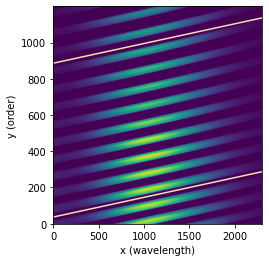

In [10]:
plt.imshow(image,aspect = 2,origin='lower')
x = np.arange(nx)
#[plt.plot(y*line_k+o,y,'wheat') for o in offset]
[plt.plot(x,x*line_k+o,'wheat') for o in offset]

plt.ylabel('y (order)')
plt.xlabel('x (wavelength)')

In [11]:
for x in np.arange(nx):
    y0 = int(x* line_k + offset[0])
    y1 = int(x*line_k +offset[-1])

    image[y1:,x] = image.min()
    image[:y0,x] = image.min()
    #print(y0,y1)    

Text(0.5, 0, 'x (wavelength)')

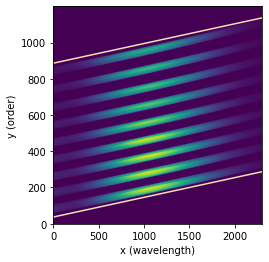

In [12]:
plt.imshow(image,aspect = 2,origin='lower')
x = np.arange(nx)
#[plt.plot(y*line_k+o,y,'wheat') for o in offset]
[plt.plot(x,x*line_k+o,'wheat') for o in offset]

plt.ylabel('y (order)')
plt.xlabel('x (wavelength)')

# Get peaks to fit order shapes
Since we removed partial orders, we can get a uniform matrix with peak positions

In [13]:
step = 200
xsection = np.arange(0,nx,step)
THRESHOLD = 0.06
MIN_DISTANCE = 60 

peaksy = []
clr = ['C0','C1']
for j,xi in enumerate(xsection):
    d = savgol_filter(image[:,xi],41,1)
    peaks = peakutils.indexes(d,thres=THRESHOLD,min_dist=MIN_DISTANCE)
    py = np.arange(ny)[peaks]
    peaksy.append(py)
peaksy = np.array(peaksy)

In [14]:
peaksy.shape

(12, 9)

In [15]:
fits = []
_ = [fits.append(np.poly1d(np.polyfit(xsection,l,2))) for l in peaksy.T]
x = np.arange(nx)
pattern = np.array([f(x) for f in fits])

Text(0.5, 0, 'x (wavelength)')

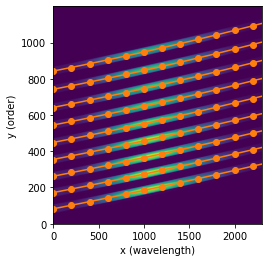

In [16]:
plt.imshow(image,aspect = 2,origin='lower')
_ = [plt.plot(xsection,y,'C1o') for y in peaksy.T]

[plt.plot(x,f(x),'C1') for f in fits]

plt.ylabel('y (order)')
plt.xlabel('x (wavelength)')

In [31]:
np.savetxt('pattern_fujii.txt', pattern.T, fmt='%.d')

In [17]:
# this is from echelle.py
def make_mask(pattern,ordind,DIMW,DIMO, show=False, **kws):
    """
    converts linear coordinates into 2d mask to mask the image
    """
    dv = kws.get("dv", 10)

    l = pattern[:, ordind]
    cc = np.arange(-dv, dv + 1, 1)
    ii = ((np.zeros([DIMW, 1]) + cc).T + l).flatten()

    jj = np.repeat(np.arange(DIMW)[np.newaxis, ...], dv * 2 + 1, axis=0,).flatten()

    mask = (ii.astype(int, copy=False), jj.astype(int, copy=False))
    if not show:
        return mask
    else:
        pp = np.zeros((DIMW, DIMO), dtype=bool)
        pp[mask] = True
        return pp

In [18]:
def make_mask(fits,ordind,DIMW,DIMO,dv):
    l = fits[ordind](x)
    cc = np.arange(-dv, dv + 1, 1)
    ii = ((np.zeros([nx, 1]) + cc).T + l).flatten()
    jj = np.repeat(np.arange(nx)[np.newaxis, ...], dv * 2 + 1, axis=0,).flatten()

    mask = (ii.astype(int, copy=False), jj.astype(int, copy=False))
    return mask

In [19]:
dv = 20
cms = [make_mask(fits,i,nx,ny, dv=dv) for i in range(len(fits))]
img = image[cms[0]]
orders = np.array([image[cm].reshape(dv * 2 + 1, nx) for cm in cms])
order_spectra = orders.sum(axis=1)

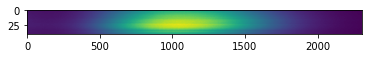

In [20]:
plt.imshow(orders[3],aspect=4)

In [21]:
orders[0].shape

(41, 2304)

In [22]:
def plot_cut_image(orders,aspect=2):
    """
    Plot images of all orders in one picture
    """

    NORD = len(orders)
    DIMW = orders[0].shape[1]
    fig, axs = plt.subplots(NORD, 1)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)
    [ax.set_xticks([]) for ax in axs[:-1]]
    [ax.set_yticks([]) for ax in axs[:-1]]
    [ax.set_xlim([0, DIMW]) for ax in axs]

    for o, ax in enumerate(reversed(axs)):
        ax.imshow(orders[o], aspect=aspect)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # ax.axis('off')
        ax.text(
            0, 0.5, o, transform=ax.transAxes, color="#fff83a", va="center", ha="left",
        )

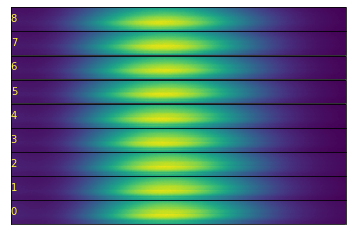

In [23]:
plot_cut_image(orders,aspect=4)

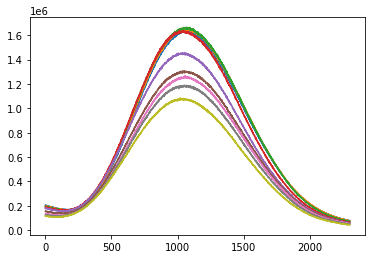

In [24]:
_ = [plt.plot(os) for os in order_spectra]

# Try H spectra

In [25]:
# Transpose to get the lines closer to horizontal
h2 = np.array(Image.open('H2-lamp-Fulcher-1s--20C.tif')).T
# Crop image
h2 = h2[1400:2600]

In [26]:
orders = np.array([h2[cm].reshape(dv * 2 + 1, nx) for cm in cms])
order_spectra = orders.sum(axis=1)

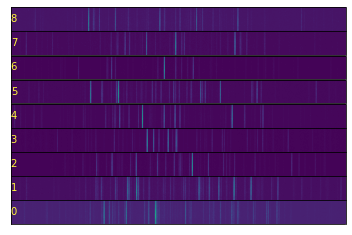

In [27]:
plot_cut_image(orders,aspect=4)

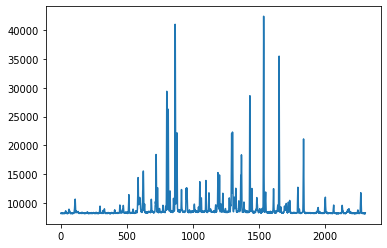

In [28]:
plt.plot(order_spectra[1])